## Stage_1 experiment

Here I investigated how well devolearn extract centroid data from various microscopy video datasets.

1. create environment
2. run ```sh install_dependencies.sh``` to install dependencies.


### import packages

In [2]:
import sys
from pathlib import Path
sys.path.append('../')
sys.path.append('../devolearn')

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import cv2
import os
import numpy as np
import torch as th
import devolearn
import PIL
from tqdm import tqdm
DATAPATH = '../data'
PREDPATH = os.path.join(DATAPATH, 'pred')

from copy import deepcopy
from importlib import reload
# import devograph.datasets.datasets as data

%matplotlib inline
%config InlineBackend.figure_format='retina'

### trying to extract centroids from videos of EPIC datasets and ipsm dataset - failed.

In [4]:
from devolearn import cell_membrane_segmentor

In [5]:
# didn't work well
segmentor = cell_membrane_segmentor()
EPIC_prefix = "EPIC/20081016_alr-1_10A2_3_L1"
ipsm_prefix = "ipsm/sm01"
EPIC_out_dir = os.path.join(PREDPATH, EPIC_prefix)
ipsm_out_dir = os.path.join(PREDPATH, ipsm_prefix)
os.makedirs(EPIC_out_dir, exist_ok=True)
os.makedirs(ipsm_out_dir, exist_ok=True)
df = segmentor.predict_from_video(video_path = os.path.join(DATAPATH, EPIC_prefix + '.mov'), centroid_mode = True, save_folder = EPIC_out_dir)
df = segmentor.predict_from_video(video_path = os.path.join(DATAPATH, ipsm_prefix + '.mov'), centroid_mode = True, save_folder = ipsm_out_dir)

saving predictions: 100%|██████████| 450/450 [01:53<00:00,  3.95it/s]


### replication - trying to extract centroids from videos of sample_data of devolearn's cell_membrane_segmentor

In [6]:
# worked
segmentor = cell_membrane_segmentor()
sample_data_dir = '../devolearn/devolearn/tests/sample_data'
sample_data_prefix = 'videos/seg_sample'
sample_data_out_dir = os.path.join(PREDPATH, sample_data_prefix)
os.makedirs(sample_data_out_dir, exist_ok=True)
df = segmentor.predict_from_video(video_path = os.path.join(sample_data_dir, sample_data_prefix + '.mov'), centroid_mode = True, save_folder = sample_data_out_dir)

saving predictions: 100%|██████████| 421/421 [01:46<00:00,  3.96it/s]


In [7]:
df.to_csv(os.path.join(sample_data_out_dir, 'centroids.csv'))

### replication - trying to extract centroids from image of sample_data of devolearn's cell_nucleus_segmentor

In [8]:
from devolearn import cell_nucleus_segmentor
segmentor = cell_nucleus_segmentor()
sample_data_dir = '../devolearn/devolearn/tests/sample_data'
sample_data_prefix = 'images/nucleus_seg_sample'
sample_data_out_dir = os.path.join(PREDPATH, sample_data_prefix)
image, centroids = segmentor.predict(image_path = os.path.join(sample_data_dir, sample_data_prefix + ".png"), centroid_mode = True)

### trying to extract centroids from image of sample_data of devolearn's cell_nucleus_segmentor

In [9]:
from devolearn import cell_nucleus_segmentor
segmentor = cell_nucleus_segmentor()

EPIC_prefix = "EPIC/20081016_alr-1_10A2_3_L1"
ipsm_prefix = "ipsm/sm01"
EPIC_out_dir = os.path.join(PREDPATH, EPIC_prefix)
ipsm_out_dir = os.path.join(PREDPATH, ipsm_prefix)
os.makedirs(EPIC_out_dir, exist_ok=True)
os.makedirs(ipsm_out_dir, exist_ok=True)
df = segmentor.predict_from_video(video_path = os.path.join(DATAPATH, EPIC_prefix + '.mov'), centroid_mode = True, save_folder = EPIC_out_dir)

saving predictions: 100%|██████████| 236/236 [01:00<00:00,  3.92it/s]


In [10]:
df.to_csv(os.path.join(EPIC_out_dir, 'centroids.csv'))

### 3D presentation - show embryo image according to time flame and slice 

download datasets from: https://figshare.com/s/d932c564d5cdd7186679 and put it in data directory.

In [127]:
mat_embryo_list = []
for flame in range(1, 96):
    mat_embryo_list.append(scipy.io.loadmat(os.path.join(DATAPATH, f'170704plc1p2/membt{flame:0>3d}.mat'))['embryo'])
print(mat_embryo_list[0].shape)

(256, 356, 70)


#### same slice, different time flame

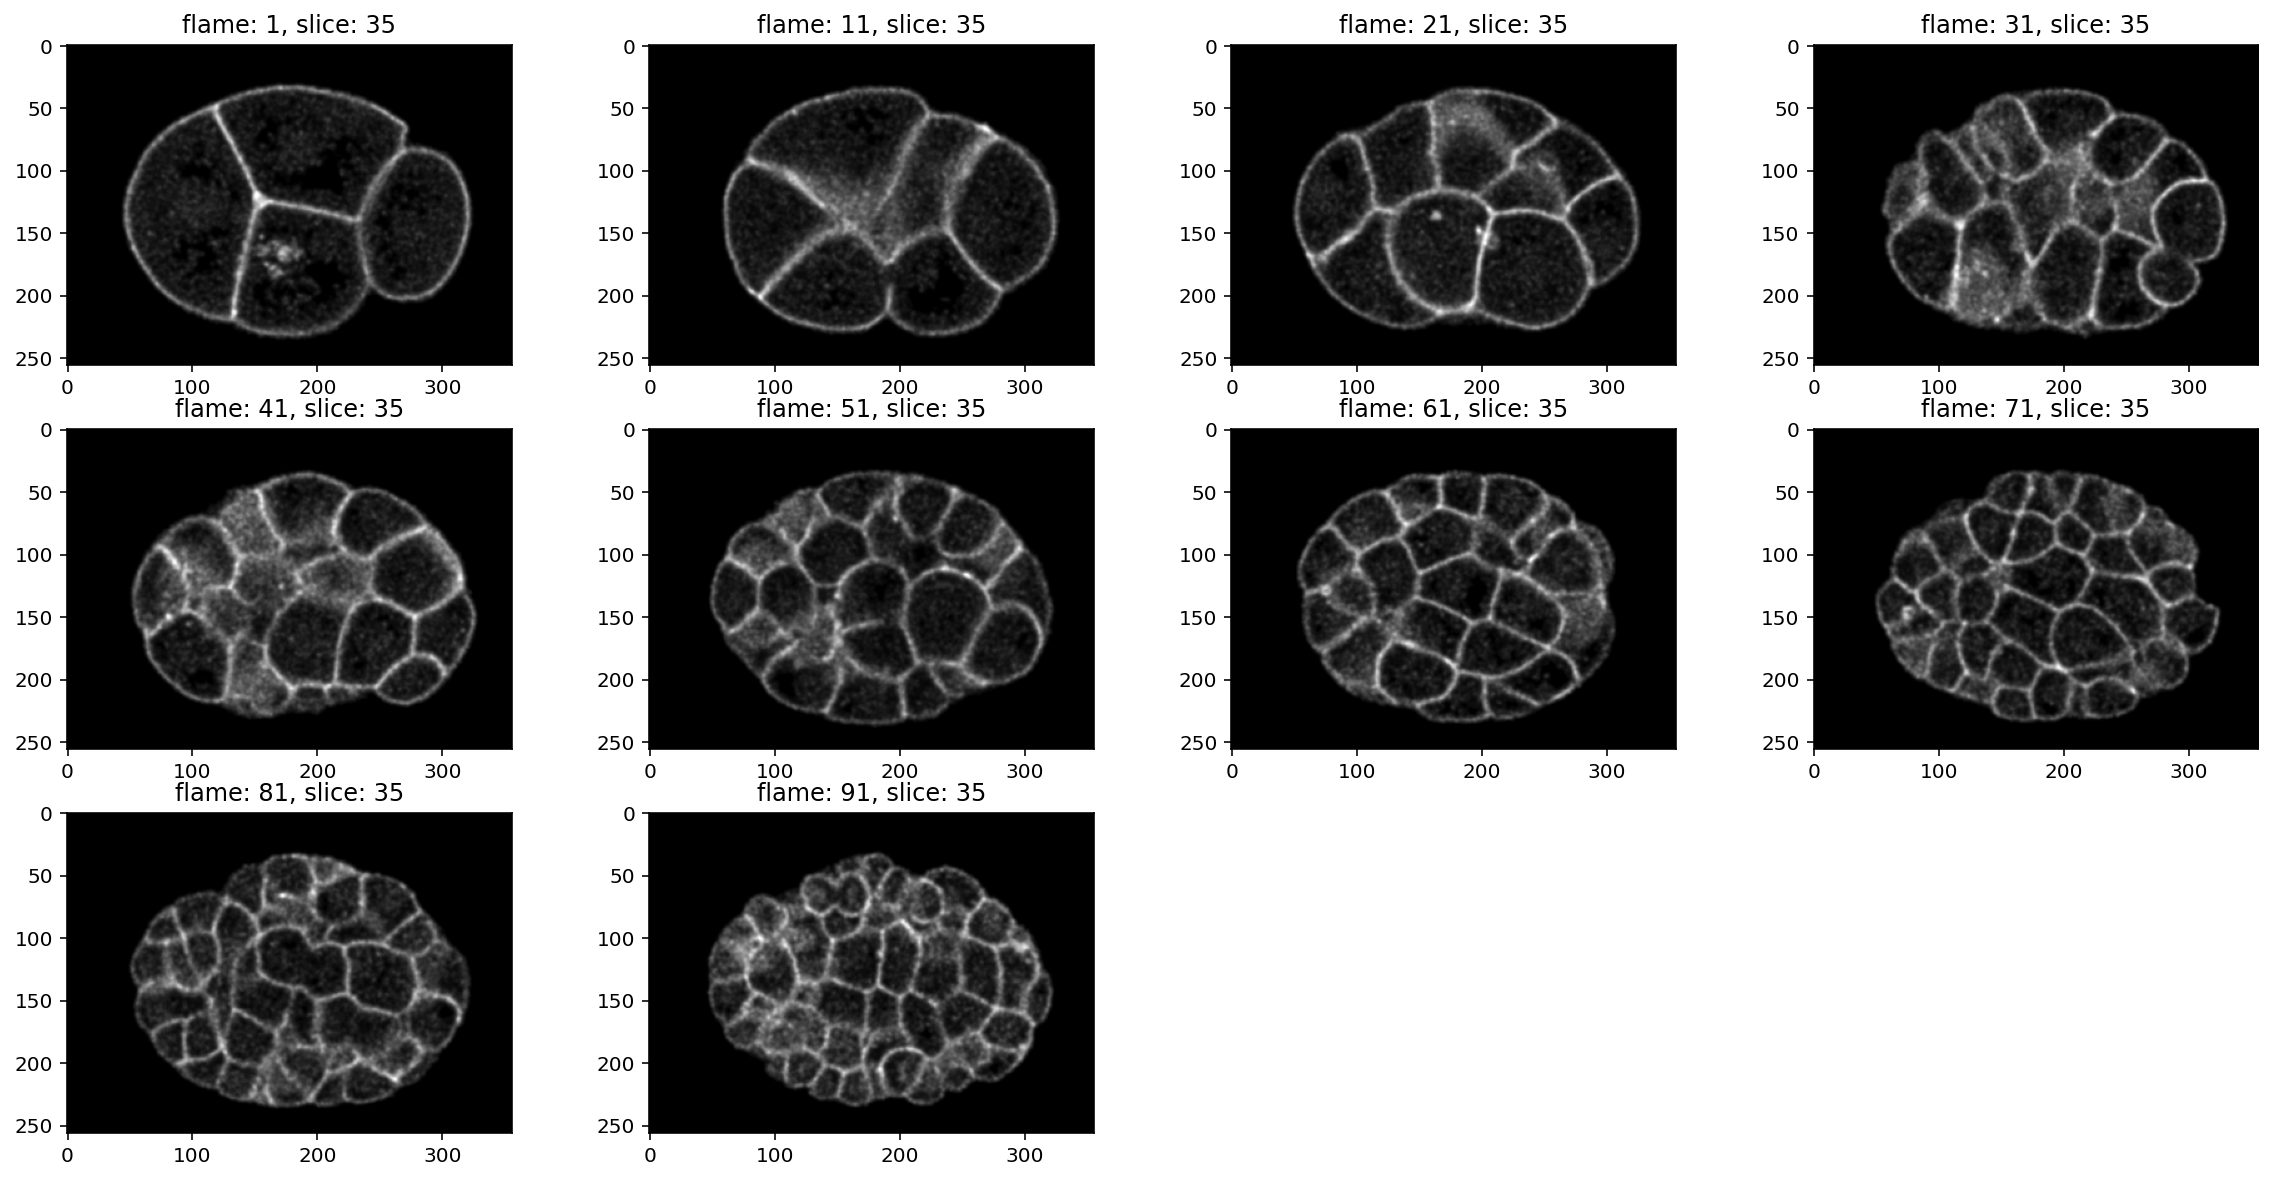

In [ ]:
slice = 35
fig = plt.figure(figsize=(20, 10))
for flame in range(0, 96, 10):
    mat = mat_embryo_list[flame]
    img = mat[..., slice]
    fig.add_subplot(3, 4, flame // 10 + 1)
    plt.imshow(img, cmap = "gray")
    plt.title(f'flame: {flame}, slice: {slice}')

#### same time flame, different slice

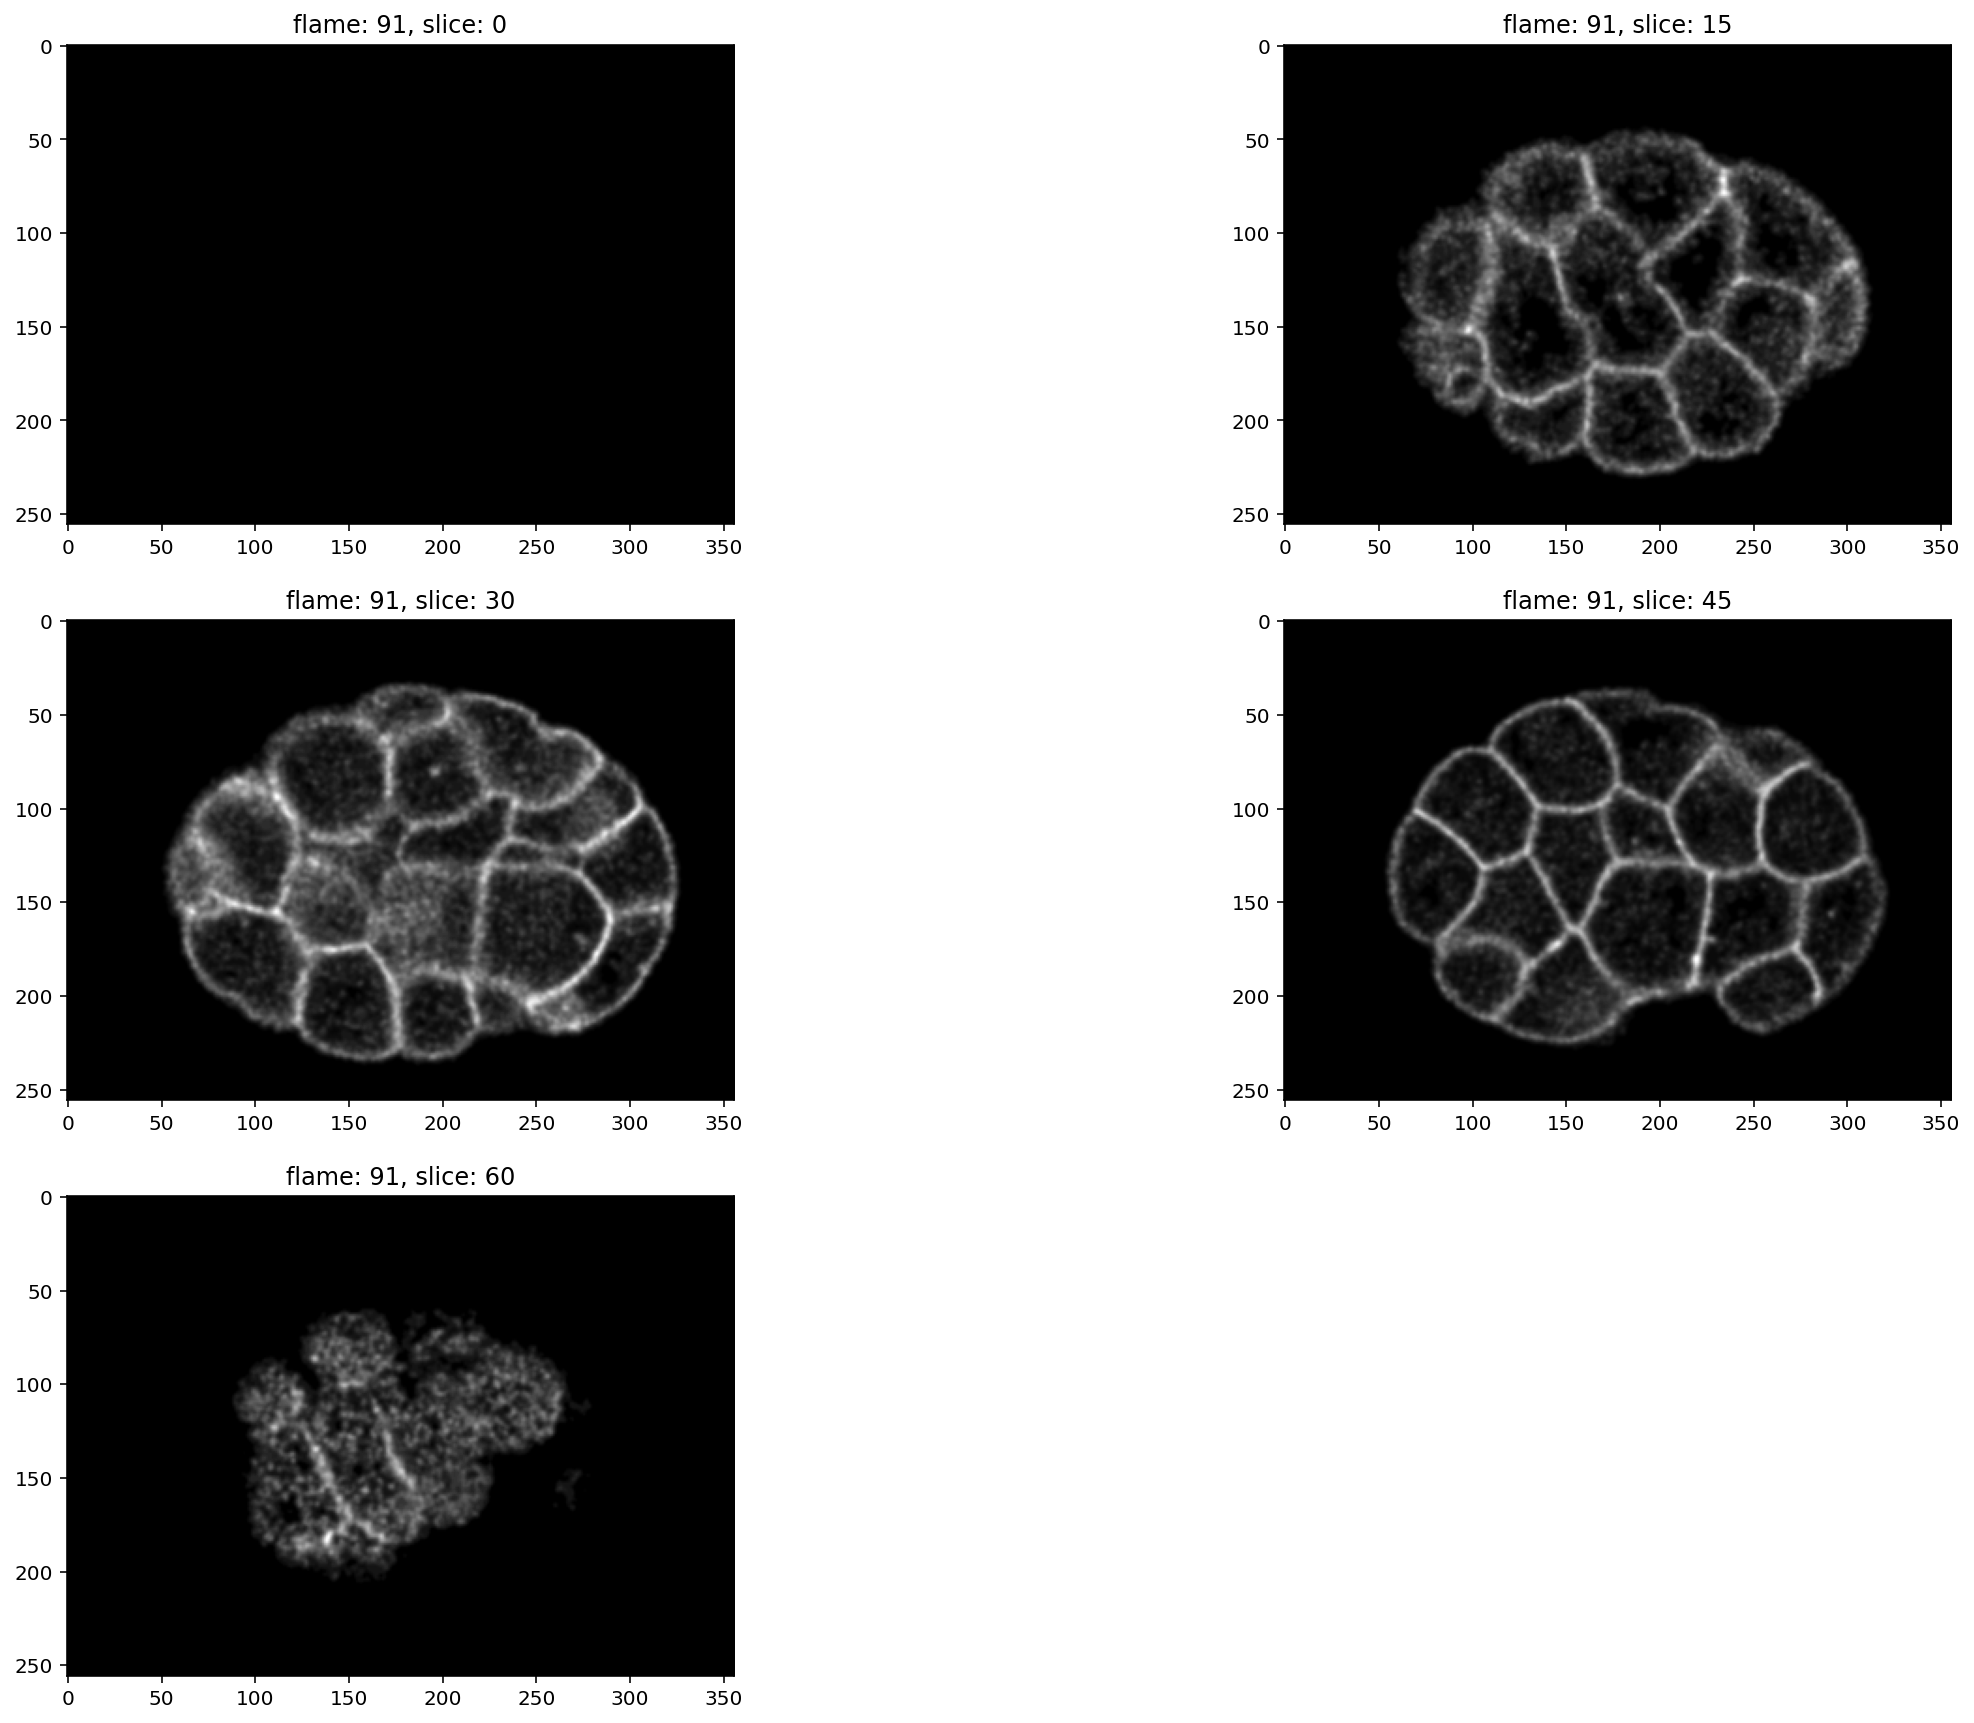

In [ ]:
mat = mat_embryo_list[45]
fig = plt.figure(figsize=(20, 15))
for slice in range(0, 70, 15):
    img = mat[..., slice]
    fig.add_subplot(3, 2, slice // 15 + 1)
    plt.imshow(img, cmap = "gray")
    plt.title(f'flame: {flame}, slice: {slice}')

### create 3D plot - you can spicify intervals of slices for z-axis as the variable "step".

In [ ]:
step = 15
from devolearn import cell_membrane_segmentor
os.makedirs('tmp', exist_ok=True)
model = cell_membrane_segmentor()
mat = mat_embryo_list[45]
centroids = []
for slice in range(0, 70):
    img = mat[..., slice]
    PIL.Image.fromarray(img).save('tmp/0.jpg')
    sg, centroid = model.predict('tmp/0.jpg', centroid_mode= True)
    centroids.append(centroid)
centroids = np.array(centroids)


In [112]:
x_s = []
y_s = []
z_s = []

for i, centroid in enumerate(centroids):
    if i % step != 0:
        continue
    x, y = [], []
    for x_, y_ in centroid:
        x.append(x_)
        y.append(y_)
    z = np.ones(len(x)) * i
    x_s.extend(x)
    y_s.extend(y)
    z_s.extend(z)

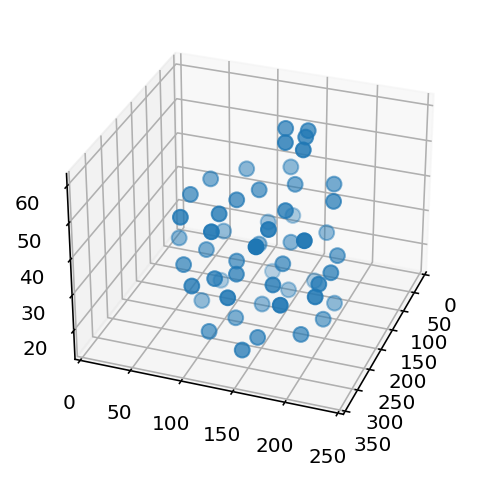

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, 350)
ax.set_ylim(0, 250)

ax.scatter(x_s, y_s, z_s, cmap = "jet", marker = "o", s = 55)
ax.view_init(30, 20)

### output for stage_2

You can specify the interval of slices in each time flame in the variable "step"

In [122]:
step = 15
from devolearn import cell_membrane_segmentor
os.makedirs('tmp', exist_ok=True)
model = cell_membrane_segmentor()
def centroids_for_time(t, emb_list, step):
    mat = emb_list[t]
    centroids = []
    for slice in range(0, 70):
        img = mat[..., slice]
        PIL.Image.fromarray(img).save('tmp/0.jpg')
        sg, centroid = model.predict('tmp/0.jpg', centroid_mode= True)
        centroids.append(centroid)
    centroids = np.array(centroids)
    x_s = []
    y_s = []
    z_s = []

    for i, centroid in enumerate(centroids):
        if i % step != 0:
            continue
        x, y = [], []
        for x_, y_ in centroid:
            x.append(x_)
            y.append(y_)
        z = np.ones(len(x)) * i
        x_s.extend(x)
        y_s.extend(y)
        z_s.extend(z)
    out_array = np.zeros((len(x_s), 5)) 
    out_array[:, 1] = t
    out_array[:, 2] = x_s
    out_array[:, 3] = y_s
    out_array[:, 4] = z_s
    return out_array
out_array = np.vstack([centroids_for_time(t, mat_embryo_list, 15) for t in tqdm(range(len(mat_embryo_list)))])


100%|██████████| 95/95 [27:33<00:00, 17.40s/it]


In [126]:
df = pd.DataFrame(out_array, columns=['cell', 'time', 'x', 'y', 'z'])
df.to_csv(os.path.join(PREDPATH, 'CE_raw_data.csv'))